<a href="https://colab.research.google.com/github/vivekshaoutlook/machine_learning/blob/master/02_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOGISTIC REGRESSION WITH NO OUT-OF-BOX MODEL USE
Problem Description: Suppose that you are the administrator of a university department and
you want to determine each applicant's chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant's scores on two exams and the admissions
decision.

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import exp
from scipy.stats import logistic
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_tnc


In [590]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#read the data and provide columns names since the csv file has no column header
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/lrdata1.csv",names=['Exam1 Score','Exam2 Score','Result'])

In [592]:
data.head()

,Exam1 Score,Exam2 Score,Result
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


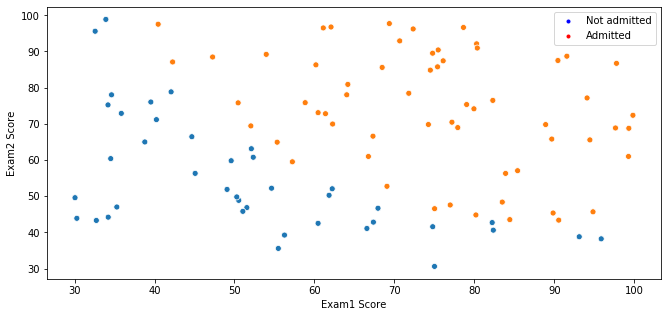

"\nAlternatively, this also works\nfrom numpy import loadtxt, where\nfrom pylab import scatter, show, legend, xlabel, ylabel\n\n#load the dataset\ndata = loadtxt('ex2data1.txt', delimiter=',')\n\nX = data[:, 0:2]\ny = data[:, 2]\n\npos = where(y == 1)\nneg = where(y == 0)\nscatter(X[pos, 0], X[pos, 1], marker='o', c='b')\nscatter(X[neg, 0], X[neg, 1], marker='x', c='r')\n\n#another way###\npositive = data[data['Admitted'].isin([1])]\nnegative = data[data['Admitted'].isin([0])]\n\nfig, ax = plt.subplots(figsize=(12,8))\nax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')\nax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')\nax.legend()\nax.set_xlabel('Exam 1 Score')\nax.set_ylabel('Exam 2 Score')\n##another way end\n\nxlabel('Exam 1 score')\nylabel('Exam 2 score')\nlegend(['Not Admitted', 'Admitted'])\nshow()\n"

In [593]:
X=data.iloc[:,0:2]
y=data.iloc[:,-1]
#let's do a scatter plot of training data for better data visualization
plt.figure(figsize=(11,5))
#using 'hue' of the scatterplot for showing realtionship between 3 varaibles
sns.scatterplot(data['Exam1 Score'],data['Exam2 Score'],hue=data['Result'])
'''below array of Line2D helps in customized legend - 'Not Admitted/Admitted
Note that the first 2 arguments, which is for data, is empty list since, we want to exploit Line2D only for legend label'''
custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
         Line2D([], [], marker='.', color='r', linestyle='None')]
plt.legend(custom,["Not admitted","Admitted"])
plt.show()

'''
Alternatively, this also works
from numpy import loadtxt, where
from pylab import scatter, show, legend, xlabel, ylabel

#load the dataset
data = loadtxt('ex2data1.txt', delimiter=',')

X = data[:, 0:2]
y = data[:, 2]

pos = where(y == 1)
neg = where(y == 0)
scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
scatter(X[neg, 0], X[neg, 1], marker='x', c='r')

#another way###
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
##another way end

xlabel('Exam 1 score')
ylabel('Exam 2 score')
legend(['Not Admitted', 'Admitted'])
show()
'''

In [0]:

m = X.shape[0] #or np.shape(X)[0]
n = X.shape[1]
#note taht after execution of the below code, X becomes a 'np array' from a 'DataFrame'
X=np.c_[np.ones((m,1)),X] #this  creates the intercept term (column of all 'prefixed' 1's )


In [0]:
#let's initialize the theta (the parameter we want to train) with all zero initially
initial_theta = np.zeros((n+1,1))
#initial_theta = np.zeros(n+1)

In [596]:
initial_theta


array([[0.],
       [0.],
       [0.]])

In [0]:
#write own sigmoid function for returning the sigmoid value
def sigmoid(z):
  #math.exp does not support array
  #sigmoid_value = 1/(1+math.exp(-z))

  #a slightly better implementation
  #sigmoid_value = logistic.cdf()

  #faster implementation
  #return expit(z)

  #best implementation for array:
  sigmoid_value = 1/(1+np.exp(-z))
  return sigmoid_value


#testing sigmoid=>1 for large positive, 0 for large negative
#print(sigmoid(np.array([90,95,-100])))


#let's write a cost function
def cost_function(theta,X,y):
  #print("type of X=",type(X))
  #print("type of y=",type(y))
  #print("type of theta=",type(theta))  
  m=X.shape[0]  

  #converting panda Series to numpy array. note that 'values' is an attribute of panda Series object.
  y=np.reshape(y.values,(m,1))

  #print("Cost shape X=",np.shape(X))
  #print("Cost shape y=",np.shape(y))
  #print("Cost shape theta=",np.shape(theta))

  
  
  J = (1/m)*(np.dot( (-(np.transpose(y))),np.log(sigmoid(np.dot(X,theta))) ) -  np.dot(np.transpose(1-y),np.log(1-sigmoid(np.dot(X,theta)))) ) 
  #since J is a matrix with only one element, we return the scalar as - np.sum(J)
  return np.sum(J)


  #the gradient function
def get_gradient(theta,X,y):    
    
    theta = np.matrix(theta)
    #theta = np.reshape(theta.values,(3,1))
    #theta.shape = (1, 3)

    #parameters = int(theta.ravel().shape[1])
    grad = np.zeros((n+1,1))
    
    
    '''
    below we converted y (a panda Series) to y.values (a numpy array). But this array had shape of (m,) . 
    so we reshaped so that the shape becomes (m,1)'''
    y=np.reshape(y.values,(m,1))

    #print("Grad shape X=",np.shape(X))
    #print("Grad shape y=",np.shape(y))
    #print("Grad shape theta Before=",np.shape(theta))

    #this transpose is done for the scipy optimization function to work properly
    if theta.shape[1] == n+1:
      theta = np.transpose(theta)
       
    #grad = (1/m) * (     np.dot( X.T,np.subtract(sigmoid( np.dot(X,theta)),np.reshape(y.values,(m,1)))   )      )
    grad = (1/m) * (     np.dot( np.transpose(X),np.subtract(sigmoid( np.dot(X,theta)),y)   )      )
    
    #print("Grad shape theta After=",np.shape(theta))
    #print("Grad Type theta After=",type(theta))
    return grad

  

In [598]:
#
#let's display the initial cost and initial gradient
cost = cost_function(initial_theta,X,y)
print("initial cost no formatting",cost)
print("initial cost is %0.3f "%(cost))
grad = get_gradient(initial_theta,X,y)
print("initial grads are",grad)
print("Grad Type=",type(grad))



initial cost no formatting 0.6931471805599453
initial cost is 0.693 
initial grads are [[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]
Grad Type= <class 'numpy.matrix'>


In [0]:
#test once more with predefined theta values
test_theta = np.array([[-24],[0.2],[0.2]])

In [600]:
test_theta

array([[-24. ],
       [  0.2],
       [  0.2]])

In [601]:
cost = cost_function(test_theta,X,y)
print("test cost is %0.3f "%(cost))
grad = get_gradient(test_theta,X,y)
print("test grads are",grad)
print("Grad Type=",type(grad))

test cost is 0.218 
test grads are [[0.04290299]
 [2.56623412]
 [2.64679737]]
Grad Type= <class 'numpy.matrix'>


In [0]:
#optimized_theta = fmin_bfgs(cost_function,x0=initial_theta,fprime=get_gradient,args=(X,y))
result = fmin_tnc(func=cost_function, x0=initial_theta, fprime=get_gradient, args=(X, y))
optimized_theta = result[0]



In [604]:
optimum_cost = cost_function(result[0], X, y)

print("optimum cost = ",optimum_cost)
print("optimum theta = ",optimized_theta)


optimum cost =  0.20349770158947436
optimum theta =  [-25.16131865   0.20623159   0.20147149]


In [0]:
#let's write a prediction function which will use the optimized_theta and the training set to predict
def predict():
  threshold=0.5
  p=np.zeros((m,1))
  p=sigmoid(X.dot(optimized_theta))
  return p>=threshold

In [0]:
p=predict()


In [609]:
np.mean(p==y)

0.89

89% accuracy of training set is what we found (Underfitting?? probably!!)